# Neural-HMM synthesis notebook

## Location of the model checkpoints

In [1]:
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [10]:
%ls checkpoints/TestRun/

checkpoint_0.ckpt      checkpoint_15500.ckpt  checkpoint_3500.ckpt
checkpoint_10000.ckpt  checkpoint_16000.ckpt  checkpoint_4000.ckpt
checkpoint_1000.ckpt   checkpoint_16500.ckpt  checkpoint_4500.ckpt
checkpoint_10500.ckpt  checkpoint_17000.ckpt  checkpoint_5000.ckpt
checkpoint_11000.ckpt  checkpoint_17500.ckpt  checkpoint_500.ckpt
checkpoint_11500.ckpt  checkpoint_18000.ckpt  checkpoint_5500.ckpt
checkpoint_12000.ckpt  checkpoint_18500.ckpt  checkpoint_6000.ckpt
checkpoint_12500.ckpt  checkpoint_19000.ckpt  checkpoint_6500.ckpt
checkpoint_13000.ckpt  checkpoint_19500.ckpt  checkpoint_7000.ckpt
checkpoint_13500.ckpt  checkpoint_20000.ckpt  checkpoint_7500.ckpt
checkpoint_14000.ckpt  checkpoint_2000.ckpt   checkpoint_8000.ckpt
checkpoint_14500.ckpt  checkpoint_20500.ckpt  checkpoint_8500.ckpt
checkpoint_15000.ckpt  checkpoint_2500.ckpt   checkpoint_9000.ckpt
checkpoint_1500.ckpt   checkpoint_3000.ckpt   checkpoint_9500.ckpt


In [11]:
checkpoint_path = "checkpoints/TestRun/checkpoint_9500.ckpt"
waveglow_path = 'waveglow/waveglow_256channels_universal_v5.pt'


## Import libraries and setup matplotlib

In [12]:
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
sys.path.append('src/model')
import numpy as np
import torch

from src.hparams import create_hparams
from src.training_module import TrainingModule
from src.utilities.text import text_to_sequence, phonetise_text
# If the below import gives error
# change the line waveglow/denoiser.py 
# from 
# --------------------------
# layers import STFT
# --------------------------
# to 
# +++++++++++++++++++++++++++
# from src.model.layers import STFT
# +++++++++++++++++++++++++++
from waveglow.denoiser import Denoiser
from nltk import word_tokenize
%matplotlib inline

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Plotting code

In [14]:
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    
def plot_hidden_states(hidden_states):
    plt.plot(hidden_state_travelled)
    plt.xlabel("Time steps")
    plt.ylabel("HMM states")
    plt.title("Hidden states vs Time")
    plt.show()

## Setup hparams

In [15]:
hparams = create_hparams()

## Load model from checkpoint

In [16]:
model = TrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.to(device).eval().half()

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,292,145 trainable parameters


## Load WaveGlow for mel2audio synthesis and denoiser

In [19]:
%%capture
waveglow = torch.load(waveglow_path)['model']
waveglow.to(device).eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

## Tune hyperparameters

### Usage
1. Increase max_sampling_time for longer utterances
2. Increase duration_quantile_threshold for faster speaking rate
3. Set deterministic_transaction as False for model sampled transition probabilities
4. Set predict_means to False to synthesis a sample instead of just means of gaussians
5. Set prenet_dropout_while_eval to False to turn off dropout in the prenet module

In [20]:
model.model.hmm.hparams.max_sampling_time = 1500
model.model.hmm.hparams.duration_quantile_threshold=0.4
model.model.hmm.hparams.deterministic_transition=True
model.model.hmm.hparams.predict_means=True
model.model.hmm.hparams.prenet_dropout_while_eval=True

## Set text

In [21]:
text = "The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent."

In [22]:
print("Input text: ", text)
text = phonetise_text(hparams.cmu_phonetiser, text, word_tokenize)
print("Phonetised text: ", text)
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.from_numpy(sequence).to(device).long()

Input text:  The Secret Service believed that it was very doubtful that any President would ride regularly in a vehicle with a fixed top, even though transparent.
Phonetised text:  {DH AH0} {S IY1 K R AH0 T} {S ER1 V AH0 S} {B IH0 L IY1 V D} {DH AE1 T} {IH1 T} {W AA1 Z} {V EH1 R IY0} {D AW1 T F AH0 L} {DH AE1 T} {EH1 N IY0} {P R EH1 Z IH0 D AH0 N T} {W UH1 D} {R AY1 D} {R EH1 G Y AH0 L ER0 L IY0} {IH0 N} {AH0} {V IY1 HH IH0 K AH0 L} {W IH1 DH} {AH0} {F IH1 K S T} {T AA1 P} , {IY1 V IH0 N} {DH OW1} {T R AE0 N S P EH1 R AH0 N T} .


## Decode text input and plot results

In [23]:
mel_outputs, hidden_state_travelled = model.inference(sequence)

### Visualisations of the output

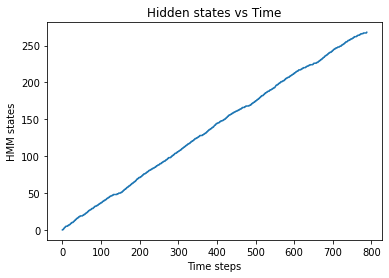

In [24]:
plot_hidden_states(hidden_state_travelled)

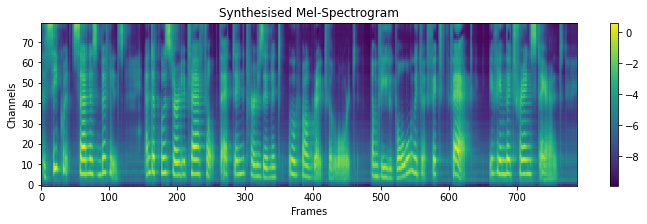

In [25]:
plot_spectrogram_to_numpy(np.array(mel_outputs).T)

In [26]:
mel_outputs = torch.tensor(mel_outputs).T.unsqueeze(0).cuda().half()

### Synthesize audio from spectrogram using WaveGlow

In [27]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)



### (Optional) Remove WaveGlow bias

In [28]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)